In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp
from scipy import stats
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score,precision_score, recall_score, roc_auc_score, log_loss, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, cross_val_score,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier , ExtraTreesClassifier, GradientBoostingClassifier,BaggingClassifier,StackingClassifier


# Replace 'your_file.csv' with the path to your CSV file.
csv_file = 'in-vehicle-coupon-recommendation.csv'

# Load the CSV file into a pandas DataFrame.
df = pd.read_csv(csv_file)
df = df.drop_duplicates()
print("Shape of dataset after removing duplicates:",df.shape)

# Drop the 'car' , 'toCoupon_GEQ5min' and 'direction_opp' columns
df = df.drop(['car', 'toCoupon_GEQ5min','direction_opp'], axis=1)

weather_col = 'weather'
temp_col = 'temperature'


# Fill missing values with the mode (most common value) of each column
df = df.fillna(df.mode().iloc[0])
# Step 1: Calculate acceptance ratio for each occupation
acceptance_ratio = df.groupby('occupation')['Y'].mean().sort_values()

Shape of dataset after removing duplicates: (12610, 26)


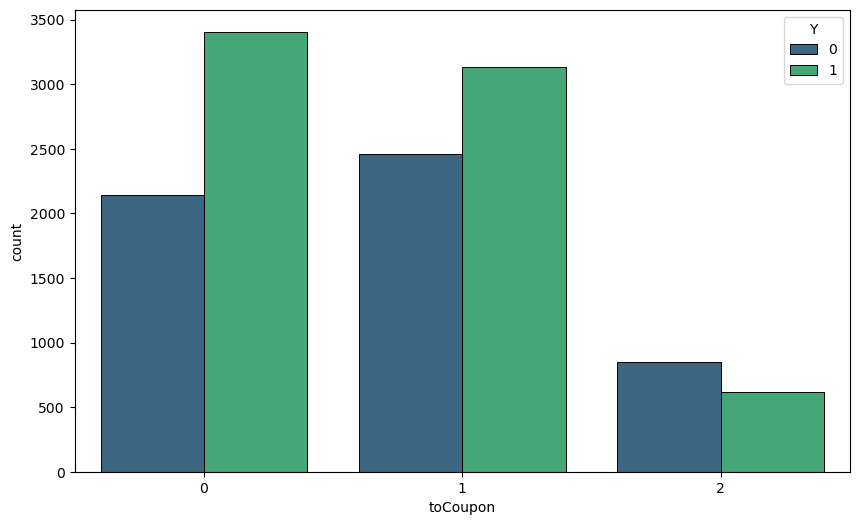

In [2]:
# Step 2: Bin occupations based on acceptance ratio
# Using quantiles as dynamic boundaries. Adjust according to your needs.
bins = [
    acceptance_ratio.min(),
    acceptance_ratio.quantile(0.2),
    acceptance_ratio.quantile(0.4),
    acceptance_ratio.quantile(0.6),
    acceptance_ratio.quantile(0.8),
    acceptance_ratio.max()
]

bin_labels = ['low', 'medium_low', 'medium', 'medium_high', 'high']

# Assign bin labels
occupation_bins = pd.cut(acceptance_ratio, bins=bins, labels=bin_labels, include_lowest=True)

# Step 3: Map original occupation to occupation_class
df['occupation'] = df['occupation'].map(occupation_bins.to_dict())


# Define a function to combine the features into 'toCoupon'
def combine_features(row):
    if row['toCoupon_GEQ15min'] == 0:  # driving distance <= 15 min
        return 0
    elif row['toCoupon_GEQ25min'] == 0 :  # driving distance > 15 min and <= 25 min
        return 1
    else:  # driving distance > 25 min
        return 2

# Apply the function to the dataframe
df['toCoupon'] = df.apply(combine_features, axis=1)

# Optionally, drop the original features
df = df.drop(['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], axis=1)
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='toCoupon', hue='Y', palette='viridis', edgecolor='black', linewidth=0.7)


# Feature Extraction for 'passenger_destination' from 'time' and 'destination'
df['time_destination'] = df['time'].astype(str) + "_" + df['destination'].astype(str)

# Feature Extraction for 'marital_hasChildren' from 'maritalStatus' and 'has_children'
df['marital_hasChildren'] = df['maritalStatus'].astype(str) + "_" + df['has_children'].astype(str)

# Feature Extraction for 'temperature_weather' from 'temperature' and 'weather'
df['temperature_weather'] = df['temperature'].astype(str) + "_" + df['weather'].astype(str)


df = df.drop(['time', 'destination', 'maritalStatus', 'has_children', 'temperature', 'weather'], axis=1)



# Define order for the ordinal variables

age_order = {'below21': 0, '21': 1, '26': 2, '31': 3, '36': 4, '41': 5, '46': 6, '50plus': 7}
education_order = {'Some High School': 0, 'High School Graduate': 1, 'Some college - no degree': 2, 'Associates degree': 3, 'Bachelors degree': 4, 'Graduate degree (Masters or Doctorate)': 5}
income_order = {'Less than $12500': 0, '$12500 - $24999': 1, '$25000 - $37499': 2, '$37500 - $49999': 3, '$50000 - $62499': 4, '$62500 - $74999': 5, '$75000 - $87499': 6, '$87500 - $99999': 7, '$100000 or More': 8}
frequency_order = {'never': 0, 'less1': 1, '1~3': 2, '4~8': 3, 'gt8': 4}
occupation_order= { 'medium_low':1, 'high':4, 'medium_high':3, 'low' :0,'medium':2}

# Replace the values based on the order
df['age'] = df['age'].replace(age_order)
df['education'] = df['education'].replace(education_order)
df['income'] = df['income'].replace(income_order)
df['occupation']=df['occupation'].replace(occupation_order)

# Encoding frequency-like features
for col in ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50']:
    df[col] = df[col].replace(frequency_order)


# 1. One-Hot Encoding
onehot_cols = ['passanger', 'coupon', 'marital_hasChildren', 'temperature_weather', 'time_destination']
encoder = OneHotEncoder(sparse_output=False, drop='first')  
encoded_cols = pd.DataFrame(encoder.fit_transform(df[onehot_cols]))

# Reset indices to ensure alignment when concatenating
encoded_cols.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Use appropriate column names for one-hot encoded columns
encoded_cols.columns = encoder.get_feature_names_out(onehot_cols)

# Concatenate the original dataframe and the one-hot encoded columns
df = pd.concat([df, encoded_cols], axis=1)

# Drop the original columns that were one-hot encoded
df.drop(onehot_cols, axis=1, inplace=True)

# 2. Binary Encoding
df['expiration'] = df['expiration'].map({'2h': 0, '1d': 1})
# Note: 'Y' and 'direction_same' are already binary, no encoding needed

# 3. Label Encoding
label_encoder = LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])  # 0 for Female and 1 for Male

# Dataframe modelling

In [3]:
# Define features (X) and target (y)
X_withY = df
X = df.drop("Y", axis=1)
y = df["Y"]
X = X.rename(columns={'coupon_Restaurant(<20)': 'coupon_Restaurant(20)'})

#save X as csv
#X.to_csv('X.csv', index=False)

# Split data into 75% train+validation and 25% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize a k-fold cross-validator (e.g., 5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Dimensionality Reduction

In [4]:
# Normalize features
scaler = StandardScaler()
X_standerdized= scaler.fit_transform(X_train_val)
# Normalize features
scaler = StandardScaler()
X_test_standerdized= scaler.fit_transform(X_test)

In [5]:
import pandas as pd

df_kmeans_pca = pd.DataFrame()
df_kmeans_tsne = pd.DataFrame()
df_agg_pca = pd.DataFrame()
df_agg_tsne = pd.DataFrame()
df_aff_pca = pd.DataFrame()
df_aff_tsne = pd.DataFrame()
df_ms_pca = pd.DataFrame()
df_ms_tsne = pd.DataFrame()
df_sc_pca = pd.DataFrame()
df_sc_tsne = pd.DataFrame()
df_db_pca = pd.DataFrame()
df_db_tsne = pd.DataFrame()
df_opt_pca = pd.DataFrame()
df_opt_tsne = pd.DataFrame()
df_birch_pca = pd.DataFrame()
df_birch_tsne = pd.DataFrame()
df_hd_pca = pd.DataFrame()
df_hd_tsne = pd.DataFrame()
df_gmm_pca = pd.DataFrame()
df_gmm_tsne = pd.DataFrame()

### PCA (Principal Component Analysis)

In [6]:
from sklearn.decomposition import PCA

# Perform PCA to reduce dimensionality to 2 dimensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_standerdized)
df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
X_test_pca = pca.transform(X_test_standerdized)
df_test_pca = pd.DataFrame(data=X_test_pca, columns=['PC1', 'PC2'], index=X_test.index)

### t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [7]:
from sklearn.manifold import TSNE

# Perform t-SNE to reduce dimensionality to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_standerdized)
df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE1', 't-SNE2'])
# Perform t-SNE on the standardized test data
X_test_tsne = tsne.fit_transform(X_test_standerdized)
df_test_tsne = pd.DataFrame(data=X_test_tsne, columns=['t-SNE1', 't-SNE2'])


## K_Means

### Finding K-Means' optimal number of clusters

/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default valu

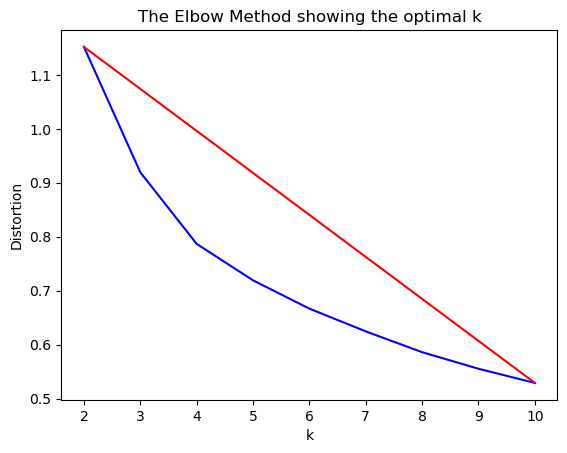

In [8]:
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn import metrics

# Initialize a list to store the average silhouette scores for each k
avg_silhouette_scores = []

# Define a range of k values to try (e.g., 2 to 10)
k_values = range(2, 11)

for k in k_values:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_pca)
    k_means.fit(X_pca)
    avg_silhouette_scores.append(sum(np.min(cdist(X_pca, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))

X_line = [k_values[0], k_values[-1]]
Y_line = [avg_silhouette_scores[0], avg_silhouette_scores[-1]]

# Plot the elbow
plt.plot(k_values, avg_silhouette_scores, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


### PCA with KMeans labels

/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


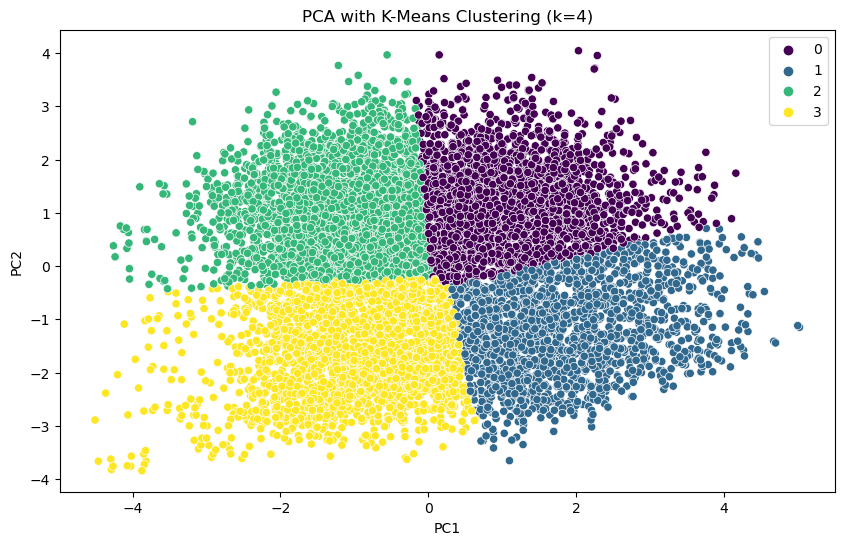

In [9]:
from sklearn.cluster import KMeans
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df_kmeans_pca = pd.DataFrame({'Cluster_Kmeans_PCA': kmeans.fit_predict(X_pca)}, index=X_train_val.index)
df_kmeans_pca_test = pd.DataFrame({'Cluster_Kmeans_PCA': kmeans.fit_predict(X_test_pca)}, index=X_test.index)
X_train_val_clustered = pd.concat([X_train_val, df_kmeans_pca['Cluster_Kmeans_PCA']], axis=1)
X_test_clustered = pd.concat([X_test, df_kmeans_pca_test['Cluster_Kmeans_PCA']], axis=1)

y_pred = kmeans.fit_predict(X_pca)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca.join(df_kmeans_pca), hue=y_pred, palette='viridis', legend='full')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with K-Means Clustering (k={})'.format(k))
plt.show()

### t-SNE with KMeans labels

/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


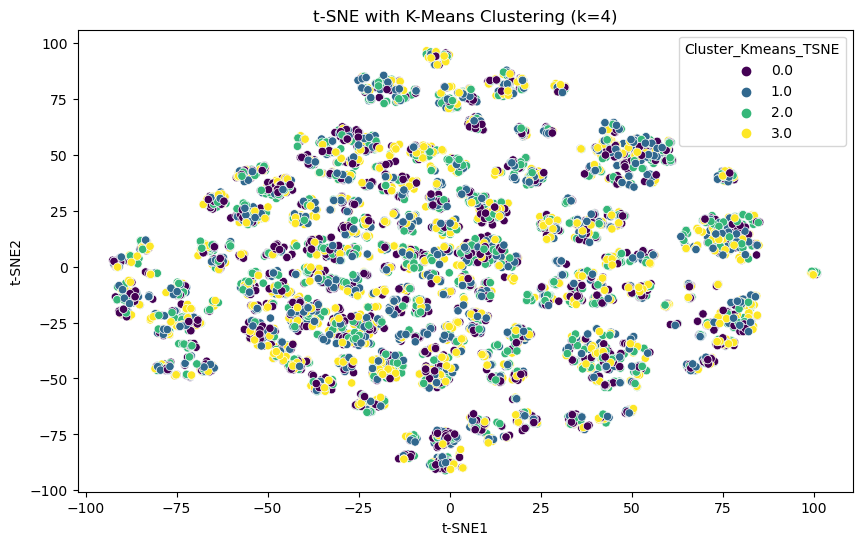

In [10]:
df_kmeans_tsne = pd.DataFrame({'Cluster_Kmeans_TSNE': kmeans.fit_predict(X_tsne)}, index=X_train_val.index)
df_kmeans_tsne_test = pd.DataFrame({'Cluster_Kmeans_TSNE': kmeans.fit_predict(X_test_tsne)}, index=X_test.index)
X_train_val_clustered = pd.concat([X_train_val, df_kmeans_tsne['Cluster_Kmeans_TSNE']], axis=1)
X_test_clustered = pd.concat([X_test, df_kmeans_tsne_test['Cluster_Kmeans_TSNE']], axis=1)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster_Kmeans_TSNE', legend='full', palette='viridis', data=df_tsne.join(df_kmeans_tsne))
plt.title('t-SNE with K-Means Clustering (k={})'.format(k))
plt.savefig("improved_cluster_tsne.png")
plt.show()

## Hierarchical Clustering

### PCA with Agglomerative method labels

/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


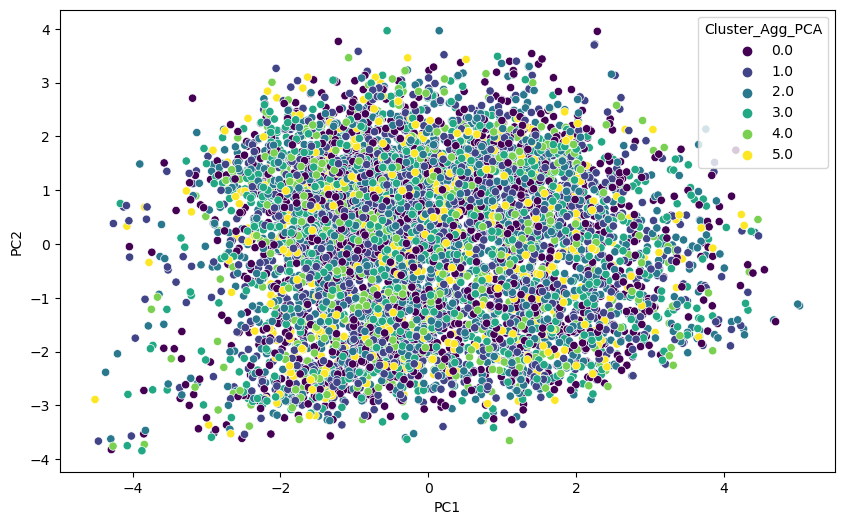

In [11]:
# Perform hierarchical clustering
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
df_agg_pca = pd.DataFrame({'Cluster_Agg_PCA': cluster.fit_predict(X_pca)}, index=X_train_val.index)
cluster_agg_pca_test = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
df_agg_pca_test = pd.DataFrame({'Cluster_Agg_PCA': cluster_agg_pca_test.fit_predict(X_test_pca)}, index=X_test.index)
X_train_val_clustered = pd.concat([X_train_val, df_agg_pca['Cluster_Agg_PCA']], axis=1)
X_test_clustered = pd.concat([X_test, df_agg_pca_test['Cluster_Agg_PCA']], axis=1)
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Agg_PCA', data=df_pca.join(df_agg_pca), palette='viridis')


plt.show()

### tSNE with Agglomerative method labels

In [12]:
linkage_methods = ['ward', 'single', 'average', 'complete']

plt.figure(figsize=(15, 10))

# Iterate over linkage methods
for i, linkage_method in enumerate(linkage_methods, 1):
    # Perform hierarchical clustering on t-SNE for train set
    cluster_agg_tsne = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')
    df_agg_tsne = pd.DataFrame({'Cluster_Agg_TSNE': cluster_agg_tsne.fit_predict(X_tsne)}, index=X_train_val.index)

# Perform hierarchical clustering on t-SNE for test set
    cluster_agg_tsne_test = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')
    df_agg_tsne_test = pd.DataFrame({'Cluster_Agg_TSNE': cluster_agg_tsne_test.fit_predict(X_test_tsne)}, index=X_test.index)

# Concatenate hierarchical clustering clusters to original data for train and test sets
    X_train_val_clustered = pd.concat([X_train_val, df_agg_tsne['Cluster_Agg_TSNE']], axis=1)
    X_test_clustered = pd.concat([X_test, df_agg_tsne_test['Cluster_Agg_TSNE']], axis=1)
    


/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/joaomloureiro/anaconda3/lib/python3.11/site-packages/sklearn/clus

<Figure size 1500x1000 with 0 Axes>

## Affinity Propagation

In [13]:
from sklearn.cluster import AffinityPropagation

# Perform Affinity Propagation clustering on PCA for train set
cluster_aff_pca = AffinityPropagation(random_state=42)
df_aff_pca = pd.DataFrame({'Cluster_Aff_PCA': cluster_aff_pca.fit_predict(X_pca)}, index=X_train_val.index)

# Perform Affinity Propagation clustering on PCA for test set
cluster_aff_pca_test = AffinityPropagation(random_state=42)
df_aff_pca_test = pd.DataFrame({'Cluster_Aff_PCA': cluster_aff_pca_test.fit_predict(X_test_pca)}, index=X_test.index)

# Perform Affinity Propagation clustering on t-SNE for train set
cluster_aff_tsne = AffinityPropagation(random_state=42)
df_aff_tsne = pd.DataFrame({'Cluster_Aff_TSNE': cluster_aff_tsne.fit_predict(X_tsne)}, index=X_train_val.index)

# Perform Affinity Propagation clustering on t-SNE for test set
cluster_aff_tsne_test = AffinityPropagation(random_state=42)
df_aff_tsne_test = pd.DataFrame({'Cluster_Aff_TSNE': cluster_aff_tsne_test.fit_predict(X_test_tsne)}, index=X_test.index)

# Concatenate Affinity Propagation clusters to original data for train and test sets
#X_train_val_clustered = pd.concat([X_train_val, df_aff_pca['Cluster_Aff_PCA']], axis=1)
#X_test_clustered = pd.concat([X_test, df_aff_pca_test['Cluster_Aff_PCA']], axis=1)
X_train_val_clustered = pd.concat([X_train_val, df_aff_tsne['Cluster_Aff_TSNE']], axis=1)
X_test_clustered = pd.concat([X_test, df_aff_tsne_test['Cluster_Aff_TSNE']], axis=1)
# Check the number of features in X_train_val_clustered and X_test_clustered
print("Number of features in X_train_val_clustered:", X_train_val_clustered.shape[1])
print("Number of features in X_test_clustered:", X_test_clustered.shape[1])

# Check for missing values in X_train_val_clustered and X_test_clustered
print("Missing values in X_train_val_clustered:", X_train_val_clustered.isnull().sum().sum())
print("Missing values in X_test_clustered:", X_test_clustered.isnull().sum().sum())

# Visualize the clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for PCA
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Aff_PCA', data=df_aff_pca.join(df_pca), palette='viridis', ax=axes[0])
axes[0].set_title('PCA with Affinity Propagation')

# Plot for t-SNE
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster_Aff_TSNE', data=df_aff_tsne.join(df_tsne), palette='viridis', ax=axes[1])
axes[1].set_title('t-SNE with Affinity Propagation')

plt.show()


KeyboardInterrupt: 

## Mean Shift

In [ ]:
from sklearn.cluster import MeanShift

# Perform Mean Shift clustering on PCA for train set
cluster_ms_pca = MeanShift(bandwidth=2)
df_ms_pca = pd.DataFrame({'Cluster_MS_PCA': cluster_ms_pca.fit_predict(X_pca)}, index=X_train_val.index)

# Perform Mean Shift clustering on PCA for test set
cluster_ms_pca_test = MeanShift(bandwidth=2)
df_ms_pca_test = pd.DataFrame({'Cluster_MS_PCA': cluster_ms_pca_test.fit_predict(X_test_pca)}, index=X_test.index)

# Perform Mean Shift clustering on t-SNE for train set
cluster_ms_tsne = MeanShift(bandwidth=2)
df_ms_tsne = pd.DataFrame({'Cluster_MS_TSNE': cluster_ms_tsne.fit_predict(X_tsne)}, index=X_train_val.index)

# Perform Mean Shift clustering on t-SNE for test set
cluster_ms_tsne_test = MeanShift(bandwidth=2)
df_ms_tsne_test = pd.DataFrame({'Cluster_MS_TSNE': cluster_ms_tsne_test.fit_predict(X_test_tsne)}, index=X_test.index)

# Concatenate Mean Shift clusters to original data for train and test sets
#X_train_val_clustered = pd.concat([X_train_val, df_ms_pca['Cluster_MS_PCA']], axis=1)
#X_test_clustered = pd.concat([X_test, df_ms_pca_test['Cluster_MS_PCA']], axis=1)
X_train_val_clustered = pd.concat([X_train_val, df_ms_tsne['Cluster_MS_TSNE']], axis=1)
X_test_clustered = pd.concat([X_test, df_ms_tsne_test['Cluster_MS_TSNE']], axis=1)



# Visualize the clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for PCA
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_MS_PCA', data=df_ms_pca.join(df_pca), palette='viridis', ax=axes[0])
axes[0].set_title('PCA with Mean Shift')

# Plot for t-SNE
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster_MS_TSNE', data=df_ms_tsne.join(df_tsne), palette='viridis', ax=axes[1])
axes[1].set_title('t-SNE with Mean Shift')

plt.show()


## Spectral Clustering

In [ ]:


from sklearn.cluster import SpectralClustering

# Perform spectral clustering 
spectral_cluster = SpectralClustering(n_clusters=6, random_state=42)
df_sc_pca = pd.DataFrame({'Cluster_Spectral_PCA': spectral_cluster.fit_predict(X_pca)}, index=X_train_val.index)
df_sc_pca_test = pd.DataFrame({'Cluster_Spectral_PCA': spectral_cluster.fit_predict(X_test_pca)}, index=X_test.index)
df_sc_tsne = pd.DataFrame({'Cluster_Spectral_TSNE': spectral_cluster.fit_predict(X_tsne)}, index=X_train_val.index)
df_sc_tsne_test = pd.DataFrame({'Cluster_Spectral_TSNE': spectral_cluster.fit_predict(X_test_tsne)}, index=X_test.index)
#X_train_val_clustered = pd.concat([X_train_val, df_sc_pca['Cluster_Spectral_PCA']], axis=1)
#X_test_clustered = pd.concat([X_test, df_sc_pca_test['Cluster_Spectral_PCA']], axis=1)
X_train_val_clustered = pd.concat([X_train_val, df_sc_tsne['Cluster_Spectral_TSNE']], axis=1)
X_test_clustered = pd.concat([X_test, df_sc_tsne_test['Cluster_Spectral_TSNE']], axis=1)

# Visualize the clusters
#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Spectral_PCA', data=df_pca.join(df_sc_pca), palette='viridis')

#plt.show()

## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering on PCA for train set
cluster_db_pca = DBSCAN(eps=2, min_samples=5)
df_db_pca = pd.DataFrame({'Cluster_DB_PCA': cluster_db_pca.fit_predict(X_pca)}, index=X_train_val.index)

# Perform DBSCAN clustering on PCA for test set
cluster_db_pca_test = DBSCAN(eps=2, min_samples=5)
df_db_pca_test = pd.DataFrame({'Cluster_DB_PCA': cluster_db_pca_test.fit_predict(X_test_pca)}, index=X_test.index)

# Perform DBSCAN clustering on t-SNE for train set
cluster_db_tsne = DBSCAN(eps=2, min_samples=5)
df_db_tsne = pd.DataFrame({'Cluster_DB_TSNE': cluster_db_tsne.fit_predict(X_tsne)}, index=X_train_val.index)

# Perform DBSCAN clustering on t-SNE for test set
cluster_db_tsne_test = DBSCAN(eps=2, min_samples=5)
df_db_tsne_test = pd.DataFrame({'Cluster_DB_TSNE': cluster_db_tsne_test.fit_predict(X_test_tsne)}, index=X_test.index)

# Concatenate DBSCAN clusters to original data for train and test sets
#X_train_val_clustered = pd.concat([X_train_val, df_db_pca['Cluster_DB_PCA']], axis=1)
#X_test_clustered = pd.concat([X_test, df_db_pca_test['Cluster_DB_PCA']], axis=1)
X_train_val_clustered = pd.concat([X_train_val, df_db_tsne['Cluster_DB_TSNE']], axis=1)
X_test_clustered = pd.concat([X_test, df_db_tsne_test['Cluster_DB_TSNE']], axis=1)

# Visualize the clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for PCA
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_DB_PCA', data=df_db_pca.join(df_pca), palette='viridis', ax=axes[0])
axes[0].set_title('PCA with DBSCAN')

# Plot for t-SNE
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster_DB_TSNE', data=df_db_tsne.join(df_tsne), palette='viridis', ax=axes[1])
axes[1].set_title('t-SNE with DBSCAN')

plt.show()


## OPTICS

In [ ]:
from sklearn.cluster import OPTICS

# Perform OPTICS clustering on PCA for train set
cluster_opt_pca = OPTICS(min_samples=5)
df_opt_pca = pd.DataFrame({'Cluster_OPT_PCA': cluster_opt_pca.fit_predict(X_pca)}, index=X_train_val.index)

# Perform OPTICS clustering on PCA for test set
cluster_opt_pca_test = OPTICS(min_samples=5)
df_opt_pca_test = pd.DataFrame({'Cluster_OPT_PCA': cluster_opt_pca_test.fit_predict(X_test_pca)}, index=X_test.index)

# Perform OPTICS clustering on t-SNE for train set
cluster_opt_tsne = OPTICS(min_samples=5)
df_opt_tsne = pd.DataFrame({'Cluster_OPT_TSNE': cluster_opt_tsne.fit_predict(X_tsne)}, index=X_train_val.index)
cluster_opt_tsne_test = OPTICS(min_samples=5)
df_opt_tsne_test = pd.DataFrame({'Cluster_OPT_TSNE': cluster_opt_tsne_test.fit_predict(X_test_tsne)}, index=X_test.index)

# Concatenate OPTICS clusters to original data for train and test sets
#X_train_val_clustered = pd.concat([X_train_val, df_opt_pca['Cluster_OPT_PCA']], axis=1)
#X_test_clustered = pd.concat([X_test, df_opt_pca_test['Cluster_OPT_PCA']], axis=1)
X_train_val_clustered = pd.concat([X_train_val, df_opt_tsne['Cluster_OPT_TSNE']], axis=1)
X_test_clustered = pd.concat([X_test, df_opt_tsne_test['Cluster_OPT_TSNE']], axis=1)



# Visualize the clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for PCA
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_OPT_PCA', data=df_opt_pca.join(df_pca), palette='viridis', ax=axes[0])
axes[0].set_title('PCA with OPTICS')

# Plot for t-SNE
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster_OPT_TSNE', data=df_opt_tsne.join(df_tsne), palette='viridis', ax=axes[1])
axes[1].set_title('t-SNE with OPTICS')

plt.show()


## BIRCH

In [ ]:
from sklearn.cluster import Birch

# Perform Birch clustering on PCA for train set
cluster_birch_pca = Birch(n_clusters=6)
df_birch_pca = pd.DataFrame({'Cluster_Birch_PCA': cluster_birch_pca.fit_predict(X_pca)}, index=X_train_val.index)

# Perform Birch clustering on PCA for test set
cluster_birch_pca_test = Birch(n_clusters=6)
df_birch_pca_test = pd.DataFrame({'Cluster_Birch_PCA': cluster_birch_pca_test.fit_predict(X_test_pca)}, index=X_test.index)

# Perform Birch clustering on t-SNE for train set
cluster_birch_tsne = Birch(n_clusters=6)
df_birch_tsne = pd.DataFrame({'Cluster_Birch_TSNE': cluster_birch_tsne.fit_predict(X_tsne)}, index=X_train_val.index)
# Perform Birch clustering on t-SNE for test set
cluster_birch_tsne_test = Birch(n_clusters=6)
df_birch_tsne_test = pd.DataFrame({'Cluster_Birch_TSNE': cluster_birch_tsne_test.fit_predict(X_test_tsne)}, index=X_test.index)

# Concatenate Birch clusters to original data for t-SNE
#X_train_val_clustered = pd.concat([X_train_val, df_birch_tsne['Cluster_Birch_TSNE']], axis=1)
#X_test_clustered = pd.concat([X_test, df_birch_tsne_test['Cluster_Birch_TSNE']], axis=1)
# Concatenate Birch clusters to original data
X_train_val_clustered = pd.concat([X_train_val, df_birch_pca['Cluster_Birch_PCA']], axis=1)
X_test_clustered = pd.concat([X_test, df_birch_pca_test['Cluster_Birch_PCA']], axis=1)



# Visualize the clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for PCA
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_Birch_PCA', data=df_birch_pca.join(df_pca), palette='viridis', ax=axes[0])
axes[0].set_title('PCA with Birch')

# Plot for t-SNE
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster_Birch_TSNE', data=df_birch_tsne.join(df_tsne), palette='viridis', ax=axes[1])
axes[1].set_title('t-SNE with Birch')

plt.show()


## HDBSCAN

In [ ]:
from sklearn.cluster import HDBSCAN

# Perform HDBSCAN clustering on PCA for train set
cluster_pca = HDBSCAN(min_cluster_size=5)
df_hd_pca = pd.DataFrame({'Cluster_PCA': cluster_pca.fit_predict(X_pca)}, index=X_train_val.index)

# Perform HDBSCAN clustering on PCA for test set
df_hd_pca_test = pd.DataFrame({'Cluster_PCA': cluster_pca.fit_predict(X_test_pca)}, index=X_test.index)

# Perform HDBSCAN clustering on t-SNE for train set
cluster_tsne = HDBSCAN(min_cluster_size=5)
df_hd_tsne = pd.DataFrame({'Cluster_TSNE': cluster_tsne.fit_predict(X_tsne)}, index=X_train_val.index)
df_hd_tsne_test = pd.DataFrame({'Cluster_TSNE': cluster_tsne.fit_predict(X_test_tsne)}, index=X_test.index)
# Concatenate clusters to original data for train and test sets
#X_train_val_clustered = pd.concat([X_train_val, df_hd_pca['Cluster_PCA']], axis=1)
#X_test_clustered = pd.concat([X_test, df_hd_pca_test['Cluster_PCA']], axis=1)
X_train_val_clustered = pd.concat([X_train_val, df_hd_tsne['Cluster_TSNE']], axis=1)
X_test_clustered = pd.concat([X_test, df_hd_tsne_test['Cluster_TSNE']], axis=1)


# Visualize the clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for PCA
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_PCA', data=df_hd_pca.join(df_pca), palette='viridis', ax=axes[0])
axes[0].set_title('PCA with HDBSCAN')

# Plot for t-SNE
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster_TSNE', data=df_hd_tsne.join(df_tsne), palette='viridis', ax=axes[1])
axes[1].set_title('t-SNE with HDBSCAN')

plt.show()



## Gaussian Mixture

In [ ]:
from sklearn.mixture import GaussianMixture

# Perform Gaussian Mixture Model clustering on PCA for train set
cluster_pca_gmm = GaussianMixture(n_components=6, random_state=42)
df_gmm_pca = pd.DataFrame({'Cluster_PCA_GMM': cluster_pca_gmm.fit_predict(X_pca)}, index=X_train_val.index)

# Perform Gaussian Mixture Model clustering on PCA for test set
cluster_pca_gmm_test = GaussianMixture(n_components=6, random_state=42)
df_gmm_pca_test = pd.DataFrame({'Cluster_PCA_GMM': cluster_pca_gmm_test.fit_predict(X_test_pca)}, index=X_test.index)

# Perform Gaussian Mixture Model clustering on t-SNE for train set
cluster_tsne_gmm = GaussianMixture(n_components=6, random_state=42)
df_gmm_tsne = pd.DataFrame({'Cluster_TSNE_GMM': cluster_tsne_gmm.fit_predict(X_tsne)}, index=X_train_val.index)
cluster_tsne_gmm_test = GaussianMixture(n_components=6, random_state=42)
df_gmm_tsne_test = pd.DataFrame({'Cluster_TSNE_GMM': cluster_tsne_gmm_test.fit_predict(X_test_tsne)}, index=X_test.index)
# Concatenate GMM clusters to original data
X_train_val_clustered= pd.concat([X_train_val, df_gmm_pca['Cluster_PCA_GMM']], axis=1)
X_test_clustered= pd.concat([X_test, df_gmm_pca_test['Cluster_PCA_GMM']], axis=1)
#X_train_val_clustered= pd.concat([X_train_val, df_gmm_tsne['Cluster_TSNE_GMM']], axis=1)
#X_test_clustered= pd.concat([X_test, df_gmm_tsne_test['Cluster_TSNE_GMM']], axis=1)
# Visualize the clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot for PCA
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_PCA_GMM', data=df_gmm_pca.join(df_pca), palette='viridis', ax=axes[0])
axes[0].set_title('PCA with Gaussian Mixture Model')

# Plot for t-SNE
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster_TSNE_GMM', data=df_gmm_tsne.join(df_tsne), palette='viridis', ax=axes[1])
axes[1].set_title('t-SNE with Gaussian Mixture Model')

plt.show()


plt.show()

# Stacking classifier

In [ ]:
import xgboost 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
# Best parameters for each model
catboost_params = {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
bagging_params = {'bootstrap': False, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
gradient_boosting_params = {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
hist_gradient_boosting_params = {'learning_rate': 0.1, 'max_depth': 15, 'max_iter': 200, 'min_samples_leaf': 10}
random_forest_params = {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
xgboost_params = {'learning_rate': 0.22000000000000003, 'max_depth': 6, 'n_estimators': 207, 'objective': 'binary:logistic', 'use_label_encoder': False}  # Added XGBoost parameters
ada_params =  {'learning_rate': 1, 'n_estimators': 150}

# Base classifiers
catboost = CatBoostClassifier(**catboost_params, random_seed=42, verbose=0)
bagging = BaggingClassifier(**bagging_params, random_state=42)
gradient_boosting = GradientBoostingClassifier(**gradient_boosting_params, random_state=42)
hist_gradient_boosting = HistGradientBoostingClassifier(**hist_gradient_boosting_params, random_state=42)
random_forest = RandomForestClassifier(**random_forest_params, random_state=42)
xgboost = XGBClassifier(**xgboost_params)  

ada = AdaBoostClassifier(**ada_params,random_state=42)

# Updated estimators list
estimators = [
    ('catboost', catboost),
    ('bagging', bagging),
    ('gradient_boosting', gradient_boosting),
    ('hist_gradient_boosting', hist_gradient_boosting),
    ('random_forest', random_forest),
    ('xgboost', xgboost),
    ('ada',ada)
]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=None, cv=kf, n_jobs=-1)

# Assuming you've already defined your training and test sets as X_train_val, y_train_val and X_test, y_test respectively
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train the stacking classifier
stacking_clf.fit(X_train_val_clustered, y_train_val)

# Make predictions on the test set
y_test_preds_stacking = stacking_clf.predict(X_test_clustered)

# Evaluating the Stacking model

# Accuracy
print("Stacking Classifier test Accuracy:", accuracy_score(y_test, y_test_preds_stacking))

# Precision
print("Stacking Classifier test Precision:", precision_score(y_test, y_test_preds_stacking))

# Recall
print("Stacking Classifier test Recall:", recall_score(y_test, y_test_preds_stacking))

# ROC-AUC for probability scores
y_test_prob_stacking = stacking_clf.predict_proba(X_test_clustered)[:, 1]
print("Stacking Classifier ROC-AUC:", roc_auc_score(y_test, y_test_prob_stacking))

# Log Loss
print("Stacking Classifier Log Loss:", log_loss(y_test, y_test_prob_stacking))

# AUC Score (using roc_curve function)
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_test_prob_stacking)
print("Stacking Classifier AUC Score:", auc(fpr_stacking, tpr_stacking))
print("Stacking Classifier report", classification_report(y_test,y_test_preds_stacking))

## External Metrics

In [46]:
from sklearn import metrics

df_mapping = {
    'df_kmeans_pca': 'Cluster_Kmeans_PCA',
    'df_kmeans_tsne': 'Cluster_Kmeans_TSNE',
    'df_agg_pca': 'Cluster_Agg_PCA',
    'df_agg_tsne': 'Cluster_Agg_TSNE',
    'df_aff_pca': 'Cluster_Aff_PCA',
    'df_aff_tsne': 'Cluster_Aff_TSNE',
    'df_ms_pca': 'Cluster_MS_PCA',
    'df_ms_tsne': 'Cluster_MS_TSNE',
    'df_sc_pca': 'Cluster_Spectral_PCA',
    'df_sc_tsne': 'Cluster_Spectral_TSNE',
    'df_db_pca': 'Cluster_DB_PCA',
    'df_db_tsne': 'Cluster_DB_TSNE',
    'df_opt_pca': 'Cluster_OPT_PCA',
    'df_opt_tsne': 'Cluster_OPT_TSNE',
    'df_birch_pca': 'Cluster_Birch_PCA',
    'df_birch_tsne': 'Cluster_Birch_TSNE',
    'df_hd_pca': 'Cluster_PCA',
    'df_hd_tsne': 'Cluster_TSNE',
    'df_gmm_pca': 'Cluster_PCA_GMM',
    'df_gmm_tsne': 'Cluster_TSNE_GMM'
}

def evaluate_external_metrics(df, cluster_label_name, target_column=None):
    adjusted_rand_score = metrics.adjusted_rand_score(df[target_column], df[cluster_label_name])
    adjusted_mutual_info_score = metrics.adjusted_mutual_info_score(df[target_column], df[cluster_label_name])
    homogeneity_score = metrics.homogeneity_score(df[target_column], df[cluster_label_name])
    completeness_score = metrics.completeness_score(df[target_column], df[cluster_label_name])
    v_measure_score = metrics.v_measure_score(df[target_column], df[cluster_label_name])
    fowlkes_mallows_score = metrics.fowlkes_mallows_score(df[target_column], df[cluster_label_name])

    print(f"{cluster_label_name}:")
    print(f"Adjusted Rand Score: {adjusted_rand_score}")
    print(f"Adjusted Mutual Information Score: {adjusted_mutual_info_score}")
    print(f"Homogeneity Score: {homogeneity_score}")
    print(f"Completeness Score: {completeness_score}")
    print(f"V-Measure Score: {v_measure_score}")
    print(f"Fowlkes Mallows Score: {fowlkes_mallows_score}")
    print()

for df_name, cluster_label_name in df_mapping.items():
    cluster_method = globals()[df_name]
    if not cluster_method.empty:
        df_metrics = pd.concat([X_train_val, cluster_method[cluster_label_name]], axis=1)
        X_train_val_clustered = pd.concat([df_metrics, y_train_val], axis=1)
        evaluate_external_metrics(X_train_val_clustered, cluster_label_name, 'Y')

Cluster_Kmeans_PCA:
Adjusted Rand Score: 0.01144957232647825
Adjusted Mutual Information Score: 0.01151902005031012
Homogeneity Score: 0.0175391149933504
Completeness Score: 0.008745924295182245
V-Measure Score: 0.011671717150771792
Fowlkes Mallows Score: 0.3703556164557246

Cluster_Kmeans_TSNE:
Adjusted Rand Score: 0.008223161918082162
Adjusted Mutual Information Score: 0.00925947975295245
Homogeneity Score: 0.014226847777573883
Completeness Score: 0.0070316763745083615
V-Measure Score: 0.009411621304058817
Fowlkes Mallows Score: 0.36389460329169937

Cluster_Agg_PCA:
Adjusted Rand Score: 0.00965738399751153
Adjusted Mutual Information Score: 0.009702391085086933
Homogeneity Score: 0.017547694795036727
Completeness Score: 0.006913440014548059
V-Measure Score: 0.00991899487112494
Fowlkes Mallows Score: 0.31420616875876256

Cluster_Agg_TSNE:
Adjusted Rand Score: 0.007820116200993174
Adjusted Mutual Information Score: 0.006738230182946119
Homogeneity Score: 0.012142077747405175
Completene

## Internal Metrics

In [42]:
from sklearn import metrics

df_mapping = {
    'df_kmeans_pca': 'Cluster_Kmeans_PCA',
    'df_kmeans_tsne': 'Cluster_Kmeans_TSNE',
    'df_agg_pca': 'Cluster_Agg_PCA',
    'df_agg_tsne': 'Cluster_Agg_TSNE',
    'df_aff_pca': 'Cluster_Aff_PCA',
    'df_aff_tsne': 'Cluster_Aff_TSNE',
    'df_ms_pca': 'Cluster_MS_PCA',
    'df_ms_tsne': 'Cluster_MS_TSNE',
    'df_sc_pca': 'Cluster_Spectral_PCA',
    'df_sc_tsne': 'Cluster_Spectral_TSNE',
    'df_db_pca': 'Cluster_DB_PCA',
    'df_db_tsne': 'Cluster_DB_TSNE',
    'df_opt_pca': 'Cluster_OPT_PCA',
    'df_opt_tsne': 'Cluster_OPT_TSNE',
    'df_birch_pca': 'Cluster_Birch_PCA',
    'df_birch_tsne': 'Cluster_Birch_TSNE',
    'df_hd_pca': 'Cluster_PCA',
    'df_hd_tsne': 'Cluster_TSNE',
    'df_gmm_pca': 'Cluster_PCA_GMM',
    'df_gmm_tsne': 'Cluster_TSNE_GMM'
}

def evaluate_internal_metrics(df, cluster_label_name, target_column=None):
    silhouette_score = metrics.silhouette_score(df.drop([cluster_label_name, target_column], axis=1), df[cluster_label_name])
    davies_bouldin_score = metrics.davies_bouldin_score(df.drop([cluster_label_name, target_column], axis=1), df[cluster_label_name])
    calinski_harabasz_score = metrics.calinski_harabasz_score(df.drop([cluster_label_name, target_column], axis=1), df[cluster_label_name])

    print(f"{cluster_label_name}:")
    print(f"Silhouette Score for {cluster_label_name}: {silhouette_score.round(4)}")
    print(f"Davies Bouldin Score for {cluster_label_name}: {davies_bouldin_score.round(4)}")
    print(f"Calinski Harabasz Score for {cluster_label_name}: {calinski_harabasz_score.round(4)}")
    print()

for df_name, cluster_label_name in df_mapping.items():
    cluster_method = globals()[df_name]
    if not cluster_method.empty:
        df_metrics = pd.concat([X_train_val, cluster_method[cluster_label_name]], axis=1)
        X_train_val_clustered = pd.concat([df_metrics, y_train_val], axis=1)
        evaluate_internal_metrics(X_train_val_clustered, cluster_label_name, 'Y')

Cluster_Kmeans_PCA:
Silhouette Score for Cluster_Kmeans_PCA: 0.0021
Davies Bouldin Score for Cluster_Kmeans_PCA: 7.0204
Calinski Harabasz Score for Cluster_Kmeans_PCA: 375.4961

Cluster_Kmeans_TSNE:
Silhouette Score for Cluster_Kmeans_TSNE: -0.0016
Davies Bouldin Score for Cluster_Kmeans_TSNE: 8.1242
Calinski Harabasz Score for Cluster_Kmeans_TSNE: 93.5105

Cluster_Agg_PCA:
Silhouette Score for Cluster_Agg_PCA: -0.0158
Davies Bouldin Score for Cluster_Agg_PCA: 7.0776
Calinski Harabasz Score for Cluster_Agg_PCA: 246.9684

Cluster_Agg_TSNE:
Silhouette Score for Cluster_Agg_TSNE: -0.0122
Davies Bouldin Score for Cluster_Agg_TSNE: 7.763
Calinski Harabasz Score for Cluster_Agg_TSNE: 65.4873



## Correlation

In [19]:
df_mapping = {
    'df_kmeans_pca': 'Cluster_Kmeans_PCA',
    'df_kmeans_tsne': 'Cluster_Kmeans_TSNE',
    'df_agg_pca': 'Cluster_Agg_PCA',
    'df_agg_tsne': 'Cluster_Agg_TSNE',
    'df_aff_pca': 'Cluster_Aff_PCA',
    'df_aff_tsne': 'Cluster_Aff_TSNE',
    'df_ms_pca': 'Cluster_MS_PCA',
    'df_ms_tsne': 'Cluster_MS_TSNE',
    'df_sc_pca': 'Cluster_Spectral_PCA',
    'df_sc_tsne': 'Cluster_Spectral_TSNE',
    'df_db_pca': 'Cluster_DB_PCA',
    'df_db_tsne': 'Cluster_DB_TSNE',
    'df_opt_pca': 'Cluster_OPT_PCA',
    'df_opt_tsne': 'Cluster_OPT_TSNE',
    'df_birch_pca': 'Cluster_Birch_PCA',
    'df_birch_tsne': 'Cluster_Birch_TSNE',
    'df_hd_pca': 'Cluster_PCA',
    'df_hd_tsne': 'Cluster_TSNE',
    'df_gmm_pca': 'Cluster_PCA_GMM',
    'df_gmm_tsne': 'Cluster_TSNE_GMM'
}

def compute_correlation(df, column_name):
    if not df.empty:
        correlation = df[column_name].corr(y)
        print(f'Correlation between {column_name} and Y: {correlation.round(4)}')

for df_name, cluster_column in df_mapping.items():
    compute_correlation(eval(df_name), cluster_column)


Correlation between Cluster_Kmeans_PCA and Y: 0.1469
Correlation between Cluster_Kmeans_TSNE and Y: -0.0599
Correlation between Cluster_Agg_PCA and Y: -0.1184
Correlation between Cluster_Agg_TSNE and Y: -0.0205
